In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import glob
import matplotlib.pyplot as plt
import seaborn as sns
#import GMM
from statsmodels.sandbox.regression.gmm import GMM, NonlinearIVGMM, LinearIVGMM
import statsmodels.api as sm
#set seaborn graphics
sns.set()
import warnings
warnings.filterwarnings('ignore')

In [2]:
pathdata = os.getcwd()+'/Data'
os.chdir(pathdata)

In [3]:
#read the data
df = pd.read_pickle('unrgdp.pkl')
newdfpc = pd.read_pickle('newdfpc.pkl')

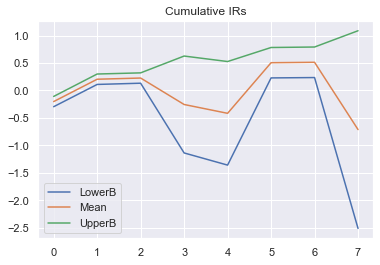

In [41]:
cumsumCI = np.zeros((8, 3))
#first estimate c0
samplesize = 72
mean = res_all.params[0] 
cov = res_all.cov_params()[0,0]*samplesize
upB = mean + 1.96*np.sqrt(cov)/np.sqrt(72)
lowB = mean - 1.96*np.sqrt(cov)/np.sqrt(72)
cumsumCI[0, 0] = lowB
cumsumCI[0, 1] = mean
cumsumCI[0, 2] = upB
#we continue for the other coefficients
for i in range(1, 8):
    #get the new mean
    mean = mean + res_all.params[i]
    #add the variance
    cov = cov + res_all.cov_params()[i,i]*samplesize
    #add the covariances
    for j in range(0, i):
        cov = cov + 2*res_all.cov_params()[j,i]*samplesize
    upB = mean + 1.96*np.sqrt(cov)/np.sqrt(72)
    lowB = mean - 1.96*np.sqrt(cov)/np.sqrt(72)
    cumsumCI[i, 0] = lowB
    cumsumCI[i, 1] = mean
    cumsumCI[i, 2] = upB
    
pd.DataFrame(cumsumCI, columns=['LowerB', 'Mean', 'UpperB'])
plt.plot(pd.DataFrame(cumsumCI, columns=['LowerB', 'Mean', 'UpperB']));
plt.legend(['LowerB', 'Mean', 'UpperB']);
plt.title('Cumulative IRs');

# GMM GDP only 

In [78]:
'''
'''
class mpGMM(GMM):
    
    def __init__(self, *args, **kwds):
        # set appropriate counts for moment conditions and parameters
        # TODO: clean up signature
        kwds.setdefault('k_moms', 10)
        kwds.setdefault('k_params', 8)
        super(mpGMM, self).__init__(*args, **kwds)


    def momcond(self, params):
        c0, c1, c2, c3, c4, c5, c6, c7  = params
        endog = self.endog
        exog = self.exog
        #defining variables
        #interaction dummies
        dQ1 = exog[:,0]
        dQ2 = exog[:,1]
        dQ3 = exog[:,2]
        dQ4 = exog[:,3]
        dTY = exog[:,4]
        #endogenous variables
        currentY_gdp = endog[:,0]
        nextY_gdp = endog[:,1]
        twoY_gdp = endog[:,2]
        rolling1_gdp = endog[:,3]
        rolling2_gdp = endog[:,4]       
        #monetary policy shock
        mp = exog[:,5]
        #next year forecasts GDP
        error1 = dQ1*mp*(nextY_gdp-mp*(1/4*c1+1/2*c2+3/4*c3+1*c4+3/4*c5+1/2*c6+1/4*c7)*dQ1)
        error2 = dQ2*mp*(nextY_gdp-mp*(1/4*c0+1/2*c1+3/4*c2+1*c3+3/4*c4+1/2*c5+1/4*c6)*dQ2)
        error3 = dQ3*mp*(nextY_gdp-mp*(1/2*c0+3/4*c1+1*c2+3/4*c3+1/2*c4+1/4*c5)*dQ3)
        error4 = dQ4*mp*(nextY_gdp-mp*(3/4*c0+1*c1+3/4*c2+1/2*c3+1/4*c4)*dQ4)
        #current year forecasts
        error5 = dQ1*mp*(currentY_gdp-mp*(c0+3/4*c1+1/2*c2+1/4*c3)*dQ1)
        error6 = dQ2*mp*(currentY_gdp-mp*(3/4*c0+1/2*c1+1/4*c2)*dQ2)
        error7 = dQ3*mp*(currentY_gdp-mp*(1/2*c0+1/4*c1)*dQ3)
        error8 = dQ4*mp*(currentY_gdp-mp*(1/4*c0)*dQ4)     
        #rolling forecasts
        error9 = mp*(rolling1_gdp-mp*(c2))
        error10 = mp*(rolling2_gdp-mp*(c6))
        g = np.column_stack((error1, error2, error3, error4, error5, error6, 
                            error7, error8, error9, error10))
        return g

#order data
dataols = pd.concat([df, newdfpc], axis=1)
var = 'ConfFactor2'
dataols = dataols.dropna(subset = [var]).iloc[:-1,:]
#time periods
dataols = dataols.loc[(dataols.index>'2002-12-01')&(dataols.index<'2014-01-01')]
#dataols = dataols.loc[dataols.index>'2002-01-01']
#create dummies
dataols['D1'] = (dataols.index.month.isin([1,2])==True)*1
dataols['D2'] = (dataols.index.month.isin([3,4])==True)*1
dataols['D3'] = (dataols.index.month.isin([7,8])==True)*1
dataols['D4'] = (dataols.index.month.isin([10,11])==True)*1
dataols['DTY'] = (dataols['TwoYearDiff_GDP'].isnull()==False)*1
dataols['TwoYearDiff_GDP'] = dataols['TwoYearDiff_GDP'].fillna(value=0)
exog = dataols[['D1', 'D2', 'D3', 'D4', 'DTY', var]]
#exog = dataols[[var]]
endog = dataols[['CurrentYearDiff_GDP', 'OneYearDiff_GDP', 'TwoYearDiff_GDP', 'R1_GDP', 'R2_GDP',
                'CurrentYearDiff_UNR', 'OneYearDiff_UNR', 'R1_UNR', 'R2_UNR']].copy()
#instr = np.asarray(exogt.iloc[:, 4:])
model = mpGMM(endog, exog,  None)
beta0 = np.zeros((1, 8))
res = model.fititer(beta0, maxiter=100, optim_method='nm',   weights_method='cov',
                  wargs={'centered':True})
#,  weights_method='cov',
#                    wargs={'centered':False}
w0 = res[1]
inv_weights = np.linalg.inv(w0)
#inv_weights =inv_weights,
res_gdp = model.fit(beta0, maxiter=10,   inv_weights =inv_weights, optim_method='nm',   weights_method='cov',
                   wargs={'centered':True})
print(res_gdp.summary(yname='GDP forecast diff', xname=['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7']))

Optimization terminated successfully.
         Current function value: 0.063565
         Iterations: 214
         Function evaluations: 317
Optimization terminated successfully.
         Current function value: 0.047344
         Iterations: 929
         Function evaluations: 1371
Optimization terminated successfully.
         Current function value: 0.044873
         Iterations: 931
         Function evaluations: 1377
Optimization terminated successfully.
         Current function value: 0.043210
         Iterations: 531
         Function evaluations: 804
Optimization terminated successfully.
         Current function value: 0.041650
         Iterations: 486
         Function evaluations: 735
Optimization terminated successfully.
         Current function value: 0.040458
         Iterations: 933
         Function evaluations: 1398
Optimization terminated successfully.
         Current function value: 0.039567
         Iterations: 441
         Function evaluations: 676
Optimization term

In [79]:
gdp_sv = res_gdp.params

# GMM for unemployment only

In [80]:
'''
'''
class mpGMM(GMM):
    
    def __init__(self, *args, **kwds):
        # set appropriate counts for moment conditions and parameters
        # TODO: clean up signature
        kwds.setdefault('k_moms', 10)
        kwds.setdefault('k_params', 8)
        super(mpGMM, self).__init__(*args, **kwds)


    def momcond(self, params):
        c0_unr, c1_unr, c2_unr, c3_unr, c4_unr, c5_unr, c6_unr, c7_unr  = params
        endog = self.endog
        exog = self.exog
        #defining variables
        #interaction dummies
        dQ1 = exog[:,0]
        dQ2 = exog[:,1]
        dQ3 = exog[:,2]
        dQ4 = exog[:,3]
        dTY = exog[:,4]
        #endogenous variables
        currentY_unr = endog[:,5]
        nextY_unr = endog[:,6]
        rolling1_unr = endog[:,7]
        rolling2_unr = endog[:,8]        
        #monetary policy shock
        mp = exog[:,5]
        #next year forecasts UNR
        error1 = dQ1*mp*(nextY_unr-mp*(1/4*c1_unr+1/2*c2_unr+3/4*c3_unr+1*c4_unr+3/4*c5_unr+1/2*c6_unr+1/4*c7_unr)*dQ1)
        error2 = dQ2*mp*(nextY_unr-mp*(1/4*c0_unr+1/2*c1_unr+3/4*c2_unr+1*c3_unr+3/4*c4_unr+1/2*c5_unr+1/4*c6_unr)*dQ2)
        error3 = dQ3*mp*(nextY_unr-mp*(1/2*c0_unr+3/4*c1_unr+1*c2_unr+3/4*c3_unr+1/2*c4_unr+1/4*c5_unr)*dQ3)
        error4 = dQ4*mp*(nextY_unr-mp*(3/4*c0_unr+1*c1_unr+3/4*c2_unr+1/2*c3_unr+1/4*c4_unr)*dQ4)
        #current year forecasts
        error5 = dQ1*mp*(currentY_unr-mp*(c0_unr+3/4*c1_unr+1/2*c2_unr+1/4*c3_unr)*dQ1)
        error6 = dQ2*mp*(currentY_unr-mp*(3/4*c0_unr+1/2*c1_unr+1/4*c2_unr)*dQ2)
        error7 = dQ3*mp*(currentY_unr-mp*(1/2*c0_unr+1/4*c1_unr)*dQ3)
        error8 = dQ4*mp*(currentY_unr-mp*(1/4*c0_unr)*dQ4)        
        #rolling forecasts
        error9 = mp*(rolling1_unr-mp*(c3_unr))
        error10 = mp*(rolling2_unr-mp*(c7_unr))
        g = np.column_stack((error1, error2, error3, error4, error5, error6, 
                            error7, error8, error9, error10))
        return g

#order data
dataols = pd.concat([df, newdfpc], axis=1)
var = 'ConfFactor2'
dataols = dataols.dropna(subset = [var]).iloc[:-1,:]
#time periods
dataols = dataols.loc[(dataols.index>'2002-12-01')&(dataols.index<'2014-01-01')]
#dataols = dataols.loc[dataols.index>'2002-01-01']
#create dummies
dataols['D1'] = (dataols.index.month.isin([1,2])==True)*1
dataols['D2'] = (dataols.index.month.isin([3,4])==True)*1
dataols['D3'] = (dataols.index.month.isin([7,8])==True)*1
dataols['D4'] = (dataols.index.month.isin([10,11])==True)*1
dataols['DTY'] = (dataols['TwoYearDiff_GDP'].isnull()==False)*1
dataols['TwoYearDiff_GDP'] = dataols['TwoYearDiff_GDP'].fillna(value=0)
exog = dataols[['D1', 'D2', 'D3', 'D4', 'DTY', var]]
#exog = dataols[[var]]
endog = dataols[['CurrentYearDiff_GDP', 'OneYearDiff_GDP', 'TwoYearDiff_GDP', 'R1_GDP', 'R2_GDP',
                'CurrentYearDiff_UNR', 'OneYearDiff_UNR', 'R1_UNR', 'R2_UNR']].copy()
#instr = np.asarray(exogt.iloc[:, 4:])
model = mpGMM(endog, exog,  None)
beta0 = np.zeros((1, 8))
res = model.fititer(beta0, maxiter=100, optim_method='nm',   weights_method='cov',
                  wargs={'centered':True})
#,  weights_method='cov',
#                    wargs={'centered':False}
w0 = res[1]
inv_weights = np.linalg.inv(w0)
#inv_weights =inv_weights,
res_unr = model.fit(beta0, maxiter=10,   inv_weights =inv_weights, optim_method='nm',   weights_method='cov',
                   wargs={'centered':True})
print(res_unr.summary(yname='GDP forecast diff', xname=['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7']))

Optimization terminated successfully.
         Current function value: 0.010643
         Iterations: 1076
         Function evaluations: 1569
Optimization terminated successfully.
         Current function value: 0.064876
         Iterations: 332
         Function evaluations: 505
Optimization terminated successfully.
         Current function value: 0.022588
         Iterations: 916
         Function evaluations: 1363
Optimization terminated successfully.
         Current function value: 0.022440
         Iterations: 133
         Function evaluations: 230
Optimization terminated successfully.
         Current function value: 0.022414
         Iterations: 154
         Function evaluations: 253
Optimization terminated successfully.
         Current function value: 0.022412
         Iterations: 108
         Function evaluations: 189
Optimization terminated successfully.
         Current function value: 0.149550
         Iterations: 982
         Function evaluations: 1448
Optimization ter

In [81]:
unr_sv = res_unr.params

# GMM with starting values from the UNR and GDP GMMs combined

In [82]:
gmm_sv = np.concatenate((gdp_sv, unr_sv), axis = 0)
gmm_sv

array([-0.25515062,  0.51130223,  0.02557128, -0.47111501, -0.48233452,
        1.30955449,  0.00787313, -1.20503028,  0.08248755, -0.18552332,
        0.06742641, -0.01005123,  0.52350287, -0.9447018 ,  0.3397832 ,
       -0.01122192])

In [84]:
'''
'''
class mpGMM(GMM):
    
    def __init__(self, *args, **kwds):
        # set appropriate counts for moment conditions and parameters
        # TODO: clean up signature
        kwds.setdefault('k_moms', 20)
        kwds.setdefault('k_params', 16)
        super(mpGMM, self).__init__(*args, **kwds)


    def momcond(self, params):
        c0, c1, c2, c3, c4, c5, c6, c7, c0_unr, c1_unr, c2_unr, c3_unr, c4_unr, c5_unr, c6_unr, c7_unr = params
        endog = self.endog
        exog = self.exog
        #defining variables
        #interaction dummies
        dQ1 = exog[:,0]
        dQ2 = exog[:,1]
        dQ3 = exog[:,2]
        dQ4 = exog[:,3]
        dTY = exog[:,4]
        #endogenous variables
        currentY_gdp = endog[:,0]
        nextY_gdp = endog[:,1]
        twoY_gdp = endog[:,2]
        rolling1_gdp = endog[:,3]
        rolling2_gdp = endog[:,4]
        currentY_unr = endog[:,5]
        nextY_unr = endog[:,6]
        rolling1_unr = endog[:,7]
        rolling2_unr = endog[:,8]        
        #monetary policy shock
        mp = exog[:,5]
        #next year forecasts GDP
        error1 = dQ1*mp*(nextY_gdp-mp*(1/4*c1+1/2*c2+3/4*c3+1*c4+3/4*c5+1/2*c6+1/4*c7)*dQ1)
        error2 = dQ2*mp*(nextY_gdp-mp*(1/4*c0+1/2*c1+3/4*c2+1*c3+3/4*c4+1/2*c5+1/4*c6)*dQ2)
        error3 = dQ3*mp*(nextY_gdp-mp*(1/2*c0+3/4*c1+1*c2+3/4*c3+1/2*c4+1/4*c5)*dQ3)
        error4 = dQ4*mp*(nextY_gdp-mp*(3/4*c0+1*c1+3/4*c2+1/2*c3+1/4*c4)*dQ4)
        #next year forecasts UNR
        error5 = dQ1*mp*(nextY_unr-mp*(1/4*c1_unr+1/2*c2_unr+3/4*c3_unr+1*c4_unr+3/4*c5_unr+1/2*c6_unr+1/4*c7_unr)*dQ1)
        error6 = dQ2*mp*(nextY_unr-mp*(1/4*c0_unr+1/2*c1_unr+3/4*c2_unr+1*c3_unr+3/4*c4_unr+1/2*c5_unr+1/4*c6_unr)*dQ2)
        error7 = dQ3*mp*(nextY_unr-mp*(1/2*c0_unr+3/4*c1_unr+1*c2_unr+3/4*c3_unr+1/2*c4_unr+1/4*c5_unr)*dQ3)
        error8 = dQ4*mp*(nextY_unr-mp*(3/4*c0_unr+1*c1_unr+3/4*c2_unr+1/2*c3_unr+1/4*c4_unr)*dQ4)
        #current year forecasts
        error9 = dQ1*mp*(currentY_gdp-mp*(c0+3/4*c1+1/2*c2+1/4*c3)*dQ1)
        error10 = dQ2*mp*(currentY_gdp-mp*(3/4*c0+1/2*c1+1/4*c2)*dQ2)
        error11 = dQ3*mp*(currentY_gdp-mp*(1/2*c0+1/4*c1)*dQ3)
        error12 = dQ4*mp*(currentY_gdp-mp*(1/4*c0)*dQ4)
        #current year forecasts
        error13 = dQ1*mp*(currentY_unr-mp*(c0_unr+3/4*c1_unr+1/2*c2_unr+1/4*c3_unr)*dQ1)
        error14 = dQ2*mp*(currentY_unr-mp*(3/4*c0_unr+1/2*c1_unr+1/4*c2_unr)*dQ2)
        error15 = dQ3*mp*(currentY_unr-mp*(1/2*c0_unr+1/4*c1_unr)*dQ3)
        error16 = dQ4*mp*(currentY_unr-mp*(1/4*c0_unr)*dQ4)        
        #rolling forecasts
        #r
        error17 = mp*(rolling1_gdp-mp*(c2))
        error18 = mp*(rolling2_gdp-mp*(c6))
        #rolling forecasts
        #r
        error19 = mp*(rolling1_unr-mp*(c3_unr))
        error20 = mp*(rolling2_unr-mp*(c7_unr))
        g = np.column_stack((error1, error2, error3, error4, error5, error6, error7, error8, error9, error10, 
                            error11, error12, error13, error14, error15, error16, error17, error18, error19, error20))
        return g

#order data
dataols = pd.concat([df, newdfpc], axis=1)
var = 'ConfFactor2'
dataols = dataols.dropna(subset = [var]).iloc[:-1,:]
#time periods
dataols = dataols.loc[(dataols.index>'2002-12-01')&(dataols.index<'2014-01-01')]
#dataols = dataols.loc[dataols.index>'2002-01-01']
#create dummies
dataols['D1'] = (dataols.index.month.isin([1,2])==True)*1
dataols['D2'] = (dataols.index.month.isin([3,4])==True)*1
dataols['D3'] = (dataols.index.month.isin([7,8])==True)*1
dataols['D4'] = (dataols.index.month.isin([10,11])==True)*1
dataols['DTY'] = (dataols['TwoYearDiff_GDP'].isnull()==False)*1
dataols['TwoYearDiff_GDP'] = dataols['TwoYearDiff_GDP'].fillna(value=0)
exog = dataols[['D1', 'D2', 'D3', 'D4', 'DTY', var]]
#exog = dataols[[var]]
endog = dataols[['CurrentYearDiff_GDP', 'OneYearDiff_GDP', 'TwoYearDiff_GDP', 'R1_GDP', 'R2_GDP',
                'CurrentYearDiff_UNR', 'OneYearDiff_UNR', 'R1_UNR', 'R2_UNR']].copy()
#instr = np.asarray(exogt.iloc[:, 4:])
model = mpGMM(endog, exog,  None)
beta0 = gmm_sv
res = model.fititer(beta0, maxiter=100, optim_method='nm',   weights_method='cov',
                  wargs={'centered':True})
#,  weights_method='cov',
#                    wargs={'centered':False}
w0 = res[1]
inv_weights = np.linalg.inv(w0)
#inv_weights =inv_weights,
res_all = model.fit(beta0, maxiter=100,   inv_weights =inv_weights, optim_method='nm',   weights_method='cov',
                   wargs={'centered':True})
print(res_all.summary(yname='GDP forecast diff', xname=['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7',
                                                   'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15']))

Optimization terminated successfully.
         Current function value: 0.071780
         Iterations: 1309
         Function evaluations: 1794
Optimization terminated successfully.
         Current function value: 0.066135
         Iterations: 831
         Function evaluations: 1202
Optimization terminated successfully.
         Current function value: 0.062573
         Iterations: 426
         Function evaluations: 676
Optimization terminated successfully.
         Current function value: 0.062558
         Iterations: 272
         Function evaluations: 451
Optimization terminated successfully.
         Current function value: 0.060819
         Iterations: 1896
         Function evaluations: 2563
Optimization terminated successfully.
         Current function value: 0.061119
         Iterations: 967
         Function evaluations: 1357
Optimization terminated successfully.
         Current function value: 0.061513
         Iterations: 252
         Function evaluations: 428
Optimization t

Optimization terminated successfully.
         Current function value: 0.061811
         Iterations: 275
         Function evaluations: 464
Optimization terminated successfully.
         Current function value: 0.060664
         Iterations: 1911
         Function evaluations: 2575
Optimization terminated successfully.
         Current function value: 0.061637
         Iterations: 387
         Function evaluations: 598
Optimization terminated successfully.
         Current function value: 0.061603
         Iterations: 259
         Function evaluations: 448
Optimization terminated successfully.
         Current function value: 0.061602
         Iterations: 293
         Function evaluations: 477
Optimization terminated successfully.
         Current function value: 0.061609
         Iterations: 284
         Function evaluations: 468
Optimization terminated successfully.
         Current function value: 0.061619
         Iterations: 261
         Function evaluations: 440
Optimization termi

In [86]:
#GDP single GMM vs combined
res_gdp.params, res_all.params[0:8]

(array([-0.25515062,  0.51130223,  0.02557128, -0.47111501, -0.48233452,
         1.30955449,  0.00787313, -1.20503028]),
 array([-0.20133383,  0.40389385,  0.0226101 , -0.3394861 , -0.45455093,
         1.08578747,  0.00787187, -0.87520146]))

In [87]:
#UNR single GMM vs combined
res_unr.params, res_all.params[8:]

(array([ 0.08248755, -0.18552332,  0.06742641, -0.01005123,  0.52350287,
        -0.9447018 ,  0.3397832 , -0.01122192]),
 array([ 0.04446293, -0.1098238 ,  0.03601004, -0.0132346 ,  0.28099766,
        -0.47594595,  0.11938879, -0.01450289]))

## compare J-stats

In [88]:
res_gdp.compare_j(res_all)

(1.017741245902471, 0.999813432058412, 10)

In [89]:
res_unr.compare_j(res_all)

(1.7276138901427633, 0.9980336816180948, 10)

## Wald test

In [90]:
r_waldtest_gdp = np.array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 1, 0, 0, 0, 0, 0, 0,  0,0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 1, 0, 0, 0, 0, 0, 0,  0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]])
r_waldtest_unr = np.array([[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0,  0, 1, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0,  0, 1, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,  0, 1, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]])
r_testsum_gdp = [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]
r_testsum_unr = [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]

In [91]:
res_all.wald_test(r_waldtest_gdp)

<class 'statsmodels.stats.contrast.ContrastResults'>
<Wald test (chi2): statistic=[[143.41586034]], p-value=4.618323577523532e-27, df_denom=8>

In [92]:
res_all.wald_test(r_waldtest_unr)

<class 'statsmodels.stats.contrast.ContrastResults'>
<Wald test (chi2): statistic=[[64.47607249]], p-value=6.125688262282518e-11, df_denom=8>

In [93]:
res_all.wald_test(r_testsum_gdp)

<class 'statsmodels.stats.contrast.ContrastResults'>
<Wald test (chi2): statistic=[[0.35712461]], p-value=0.5501075063834211, df_denom=1>

In [94]:
res_all.wald_test(r_testsum_unr)

<class 'statsmodels.stats.contrast.ContrastResults'>
<Wald test (chi2): statistic=[[0.58475641]], p-value=0.4444539772347753, df_denom=1>

## Okun's Law test

In [95]:
rmatrix = np.array([[1, 0, 0, 0, 0, 0, 0, 0, -1.8, 0, 0, 0, 0, 0, 0, 0],
                    [0, 1, 0, 0, 0, 0, 0, 0, 0, -1.8, 0, 0, 0, 0, 0, 0],
                    [0, 0, 1, 0, 0, 0, 0, 0, 0,  0,-1.8, 0, 0, 0, 0, 0],
                    [0, 0, 0, 1, 0, 0, 0, 0, 0, 0,  0,-1.8, 0, 0, 0, 0],
                    [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,  0,-1.8, 0, 0, 0],
                    [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, -1.8, 0, 0],
                    [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, -1.8, 0],
                    [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, -1.8]])

In [96]:
res_all.t_test(rmatrix)

<class 'statsmodels.stats.contrast.ContrastResults'>
                             Test for Constraints                             
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
c0            -0.2814      0.095     -2.954      0.003      -0.468      -0.095
c1             0.6016      0.191      3.150      0.002       0.227       0.976
c2            -0.0422      0.122     -0.345      0.730      -0.282       0.198
c3            -0.3157      0.299     -1.054      0.292      -0.902       0.271
c4            -0.9603      0.918     -1.046      0.296      -2.760       0.840
c5             1.9425      0.770      2.523      0.012       0.434       3.451
c6            -0.2070      0.366     -0.566      0.572      -0.924       0.510
c7            -0.8491      0.585     -1.452      0.146      -1.995       0.297

### GDP IRFs

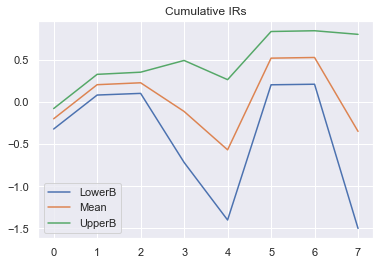

In [97]:
cumsumCI = np.zeros((8, 3))
#first estimate c0
samplesize = 72
mean = res_all.params[0] 
cov = res_all.cov_params()[0,0]*samplesize
upB = mean + 1.96*np.sqrt(cov)/np.sqrt(72)
lowB = mean - 1.96*np.sqrt(cov)/np.sqrt(72)
cumsumCI[0, 0] = lowB
cumsumCI[0, 1] = mean
cumsumCI[0, 2] = upB
#we continue for the other coefficients
for i in range(1, 8):
    #get the new mean
    mean = mean + res_all.params[i]
    #add the variance
    cov = cov + res_all.cov_params()[i,i]*samplesize
    #add the covariances
    for j in range(0, i):
        cov = cov + 2*res_all.cov_params()[j,i]*samplesize
    upB = mean + 1.96*np.sqrt(cov)/np.sqrt(72)
    lowB = mean - 1.96*np.sqrt(cov)/np.sqrt(72)
    cumsumCI[i, 0] = lowB
    cumsumCI[i, 1] = mean
    cumsumCI[i, 2] = upB
    
pd.DataFrame(cumsumCI, columns=['LowerB', 'Mean', 'UpperB'])
plt.plot(pd.DataFrame(cumsumCI, columns=['LowerB', 'Mean', 'UpperB']));
plt.legend(['LowerB', 'Mean', 'UpperB']);
plt.title('Cumulative IRs');

### Unemployment IRFs

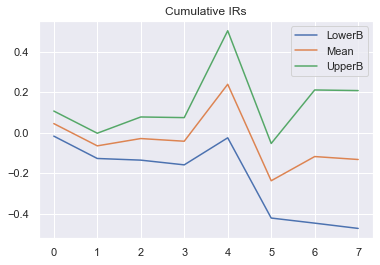

In [100]:
cumsumCI = np.zeros((8, 3))
#first estimate c0
samplesize = 72
mean = res_all.params[8] 
cov = res_all.cov_params()[8,8]*samplesize
upB = mean + 1.96*np.sqrt(cov)/np.sqrt(72)
lowB = mean - 1.96*np.sqrt(cov)/np.sqrt(72)
cumsumCI[0, 0] = lowB
cumsumCI[0, 1] = mean
cumsumCI[0, 2] = upB
#we continue for the other coefficients
for i in range(9, 16):
    #get the new mean
    mean = mean + res_all.params[i]
    #add the variance
    cov = cov + res_all.cov_params()[i,i]*samplesize
    #add the covariances
    for j in range(8, i):
        cov = cov + 2*res_all.cov_params()[j,i]*samplesize
    upB = mean + 1.96*np.sqrt(cov)/np.sqrt(72)
    lowB = mean - 1.96*np.sqrt(cov)/np.sqrt(72)
    cumsumCI[i-8, 0] = lowB
    cumsumCI[i-8, 1] = mean
    cumsumCI[i-8, 2] = upB
    
pd.DataFrame(cumsumCI, columns=['LowerB', 'Mean', 'UpperB'])
plt.plot(pd.DataFrame(cumsumCI, columns=['LowerB', 'Mean', 'UpperB']));
plt.legend(['LowerB', 'Mean', 'UpperB']);
plt.title('Cumulative IRs');

# GMM GDP with starting values from combined

In [26]:
'''
'''
class mpGMM(GMM):
    
    def __init__(self, *args, **kwds):
        # set appropriate counts for moment conditions and parameters
        # TODO: clean up signature
        kwds.setdefault('k_moms', 10)
        kwds.setdefault('k_params', 8)
        super(mpGMM, self).__init__(*args, **kwds)


    def momcond(self, params):
        c0, c1, c2, c3, c4, c5, c6, c7  = params
        endog = self.endog
        exog = self.exog
        #defining variables
        #interaction dummies
        dQ1 = exog[:,0]
        dQ2 = exog[:,1]
        dQ3 = exog[:,2]
        dQ4 = exog[:,3]
        dTY = exog[:,4]
        #endogenous variables
        currentY_gdp = endog[:,0]
        nextY_gdp = endog[:,1]
        twoY_gdp = endog[:,2]
        rolling1_gdp = endog[:,3]
        rolling2_gdp = endog[:,4]       
        #monetary policy shock
        mp = exog[:,5]
        #next year forecasts GDP
        error1 = dQ1*mp*(nextY_gdp-mp*(1/4*c1+1/2*c2+3/4*c3+1*c4+3/4*c5+1/2*c6+1/4*c7)*dQ1)
        error2 = dQ2*mp*(nextY_gdp-mp*(1/4*c0+1/2*c1+3/4*c2+1*c3+3/4*c4+1/2*c5+1/4*c6)*dQ2)
        error3 = dQ3*mp*(nextY_gdp-mp*(1/2*c0+3/4*c1+1*c2+3/4*c3+1/2*c4+1/4*c5)*dQ3)
        error4 = dQ4*mp*(nextY_gdp-mp*(3/4*c0+1*c1+3/4*c2+1/2*c3+1/4*c4)*dQ4)
        #current year forecasts
        error5 = dQ1*mp*(currentY_gdp-mp*(c0+3/4*c1+1/2*c2+1/4*c3)*dQ1)
        error6 = dQ2*mp*(currentY_gdp-mp*(3/4*c0+1/2*c1+1/4*c2)*dQ2)
        error7 = dQ3*mp*(currentY_gdp-mp*(1/2*c0+1/4*c1)*dQ3)
        error8 = dQ4*mp*(currentY_gdp-mp*(1/4*c0)*dQ4)     
        #rolling forecasts
        error9 = mp*(rolling1_gdp-mp*(c2))
        error10 = mp*(rolling2_gdp-mp*(c6))
        g = np.column_stack((error1, error2, error3, error4, error5, error6, 
                            error7, error8, error9, error10))
        return g

#order data
dataols = pd.concat([df, newdfpc], axis=1)
var = 'ConfFactor2'
dataols = dataols.dropna(subset = [var]).iloc[:-1,:]
#time periods
dataols = dataols.loc[(dataols.index>'2001-12-01')&(dataols.index<'2015-01-01')]
#dataols = dataols.loc[dataols.index>'2002-01-01']
#create dummies
dataols['D1'] = (dataols.index.month.isin([1,2])==True)*1
dataols['D2'] = (dataols.index.month.isin([3,4])==True)*1
dataols['D3'] = (dataols.index.month.isin([7,8])==True)*1
dataols['D4'] = (dataols.index.month.isin([10,11])==True)*1
dataols['DTY'] = (dataols['TwoYearDiff_GDP'].isnull()==False)*1
dataols['TwoYearDiff_GDP'] = dataols['TwoYearDiff_GDP'].fillna(value=0)
exog = dataols[['D1', 'D2', 'D3', 'D4', 'DTY', var]]
#exog = dataols[[var]]
endog = dataols[['CurrentYearDiff_GDP', 'OneYearDiff_GDP', 'TwoYearDiff_GDP', 'R1_GDP', 'R2_GDP',
                'CurrentYearDiff_UNR', 'OneYearDiff_UNR', 'R1_UNR', 'R2_UNR']].copy()
#instr = np.asarray(exogt.iloc[:, 4:])
model = mpGMM(endog, exog,  None)
beta0 = res_all.params[:8]
res = model.fititer(beta0, maxiter=100, optim_method='nm',   weights_method='cov',
                  wargs={'centered':True})
#,  weights_method='cov',
#                    wargs={'centered':False}
w0 = res[1]
inv_weights = np.linalg.inv(w0)
#inv_weights =inv_weights,
res_gdp1 = model.fit(beta0, maxiter=10,   inv_weights =inv_weights, optim_method='nm',   weights_method='cov',
                   wargs={'centered':True})
print(res_gdp1.summary(yname='GDP forecast diff', xname=['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7']))

Optimization terminated successfully.
         Current function value: 0.005383
         Iterations: 675
         Function evaluations: 993
Optimization terminated successfully.
         Current function value: 0.063014
         Iterations: 685
         Function evaluations: 1029
Optimization terminated successfully.
         Current function value: 0.065278
         Iterations: 551
         Function evaluations: 835
Optimization terminated successfully.
         Current function value: 0.045657
         Iterations: 258
         Function evaluations: 416
Optimization terminated successfully.
         Current function value: 0.041905
         Iterations: 406
         Function evaluations: 640
Optimization terminated successfully.
         Current function value: 0.040916
         Iterations: 484
         Function evaluations: 727
Optimization terminated successfully.
         Current function value: 0.040522
         Iterations: 767
         Function evaluations: 1141
Optimization termi

In [27]:
res_gdp1.params, res_gdp.params, res_all.params[:8]

(array([-0.28,  0.57,  0.02, -0.56, -0.43,  1.37,  0.01, -1.42]),
 array([-0.28,  0.55,  0.02, -0.55, -0.4 ,  1.33,  0.01, -1.4 ]),
 array([-0.2 ,  0.41,  0.02, -0.48, -0.16,  0.92,  0.01, -1.22]))

In [33]:
res_all.jtest()

(2.701246519894351, 0.6089965051515447, 4)

# UNR with starting values from the combined GMM

In [28]:
'''
'''
class mpGMM(GMM):
    
    def __init__(self, *args, **kwds):
        # set appropriate counts for moment conditions and parameters
        # TODO: clean up signature
        kwds.setdefault('k_moms', 10)
        kwds.setdefault('k_params', 8)
        super(mpGMM, self).__init__(*args, **kwds)


    def momcond(self, params):
        c0_unr, c1_unr, c2_unr, c3_unr, c4_unr, c5_unr, c6_unr, c7_unr  = params
        endog = self.endog
        exog = self.exog
        #defining variables
        #interaction dummies
        dQ1 = exog[:,0]
        dQ2 = exog[:,1]
        dQ3 = exog[:,2]
        dQ4 = exog[:,3]
        dTY = exog[:,4]
        #endogenous variables
        currentY_unr = endog[:,5]
        nextY_unr = endog[:,6]
        rolling1_unr = endog[:,7]
        rolling2_unr = endog[:,8]        
        #monetary policy shock
        mp = exog[:,5]
        #next year forecasts UNR
        error1 = dQ1*mp*(nextY_unr-mp*(1/4*c1_unr+1/2*c2_unr+3/4*c3_unr+1*c4_unr+3/4*c5_unr+1/2*c6_unr+1/4*c7_unr)*dQ1)
        error2 = dQ2*mp*(nextY_unr-mp*(1/4*c0_unr+1/2*c1_unr+3/4*c2_unr+1*c3_unr+3/4*c4_unr+1/2*c5_unr+1/4*c6_unr)*dQ2)
        error3 = dQ3*mp*(nextY_unr-mp*(1/2*c0_unr+3/4*c1_unr+1*c2_unr+3/4*c3_unr+1/2*c4_unr+1/4*c5_unr)*dQ3)
        error4 = dQ4*mp*(nextY_unr-mp*(3/4*c0_unr+1*c1_unr+3/4*c2_unr+1/2*c3_unr+1/4*c4_unr)*dQ4)
        #current year forecasts
        error5 = dQ1*mp*(currentY_unr-mp*(c0_unr+3/4*c1_unr+1/2*c2_unr+1/4*c3_unr)*dQ1)
        error6 = dQ2*mp*(currentY_unr-mp*(3/4*c0_unr+1/2*c1_unr+1/4*c2_unr)*dQ2)
        error7 = dQ3*mp*(currentY_unr-mp*(1/2*c0_unr+1/4*c1_unr)*dQ3)
        error8 = dQ4*mp*(currentY_unr-mp*(1/4*c0_unr)*dQ4)        
        #rolling forecasts
        error9 = mp*(rolling1_unr-mp*(c2_unr))
        error10 = mp*(rolling2_unr-mp*(c6_unr))
        g = np.column_stack((error1, error2, error3, error4, error5, error6, 
                            error7, error8, error9, error10))
        return g

#order data
dataols = pd.concat([df, newdfpc], axis=1)
var = 'ConfFactor2'
dataols = dataols.dropna(subset = [var]).iloc[:-1,:]
#time periods
dataols = dataols.loc[(dataols.index>'2001-12-01')&(dataols.index<'2015-01-01')]
#dataols = dataols.loc[dataols.index>'2002-01-01']
#create dummies
dataols['D1'] = (dataols.index.month.isin([1,2])==True)*1
dataols['D2'] = (dataols.index.month.isin([3,4])==True)*1
dataols['D3'] = (dataols.index.month.isin([7,8])==True)*1
dataols['D4'] = (dataols.index.month.isin([10,11])==True)*1
dataols['DTY'] = (dataols['TwoYearDiff_GDP'].isnull()==False)*1
dataols['TwoYearDiff_GDP'] = dataols['TwoYearDiff_GDP'].fillna(value=0)
exog = dataols[['D1', 'D2', 'D3', 'D4', 'DTY', var]]
#exog = dataols[[var]]
endog = dataols[['CurrentYearDiff_GDP', 'OneYearDiff_GDP', 'TwoYearDiff_GDP', 'R1_GDP', 'R2_GDP',
                'CurrentYearDiff_UNR', 'OneYearDiff_UNR', 'R1_UNR', 'R2_UNR']].copy()
#instr = np.asarray(exogt.iloc[:, 4:])
model = mpGMM(endog, exog,  None)
beta0 = res_all.params[8:]
res = model.fititer(beta0, maxiter=100, optim_method='nm',   weights_method='cov',
                  wargs={'centered':True})
#,  weights_method='cov',
#                    wargs={'centered':False}
w0 = res[1]
inv_weights = np.linalg.inv(w0)
#inv_weights =inv_weights,
res_unr1 = model.fit(beta0, maxiter=10,   inv_weights =inv_weights, optim_method='nm',   weights_method='cov',
                   wargs={'centered':True})
print(res_unr1.summary(yname='GDP forecast diff', xname=['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7']))

Optimization terminated successfully.
         Current function value: 0.002014
         Iterations: 639
         Function evaluations: 944
Optimization terminated successfully.
         Current function value: 0.008568
         Iterations: 540
         Function evaluations: 822
Optimization terminated successfully.
         Current function value: 0.008619
         Iterations: 138
         Function evaluations: 243
Optimization terminated successfully.
         Current function value: 0.008606
         Iterations: 163
         Function evaluations: 278
Optimization terminated successfully.
         Current function value: 0.008600
         Iterations: 192
         Function evaluations: 320
Optimization terminated successfully.
         Current function value: 0.008597
         Iterations: 109
         Function evaluations: 198
Optimization terminated successfully.
         Current function value: 0.008580
         Iterations: 309
         Function evaluations: 478
Optimization termina

In [29]:
res_unr1.params, res_unr.params, res_all.params[8:]

(array([ 0.07, -0.16, -0.01,  0.08,  0.5 , -0.91, -0.01,  0.55]),
 array([ 0.07, -0.16, -0.01,  0.08,  0.52, -0.92, -0.01,  0.54]),
 array([-0.01,  0.  , -0.01, -0.05,  0.18, -0.19, -0.01, -0.03]))

In [30]:
res_gdp.compare_j(res_gdp1)

(0.013384204994188131, nan, 0)

In [31]:
res_unr.compare_j(res_unr1)

(0.0007269098944691077, nan, 0)